# Motion Imagery Notebook - Gamma Group, Neuro VR Project

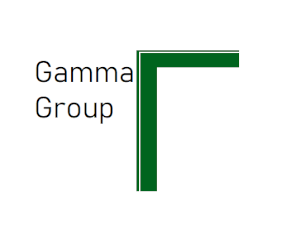

> All code below is owned by Gamma Group, a BCI research student organization at UC San Diego.
> Anyone may use the code below for personal exploration, however, direct use of our code for personal gain(publishing papers, commerical pursuits, etc.) is strictly forbidden.

### Interested in joining? Contact Tekin
### Number: 859-556-3577
### Email: tgunasar@ucsd.edu

## Downloading necessary libraries and Setting up Helper Classes 

>Downloading neccessary libraries. This has a rather long output. Throughout this notebook <br>
use Esc+o to hide outputs

In [14]:
!pip install matplotlib
!pip install pandas
!pip install tsaug
!pip install numpy
!pip install sklearn
!pip install seaborn

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


### Data Visualization Class

In [15]:
from numpy import array,shape,transpose
import matplotlib.pyplot as plt
from tsaug.visualization import plot
from math import floor
import pandas as pd
import os


from pickle import load,dump

class Visualizer:

    SAMPLING_RATE = 300
    NUM_CHANNELS = 7

    x = []
    y = []

    def __init__(self,dataSet,labels):
        self.dataSet = load(open(dataSet,'rb'))
        self.labels = labels

    def getX(self):
        return self.dataSet[0]

    def getY(self):
        return self.dataSet[1]

    def getLabelDistribution(self,label):
        x = self.getX()
        y = self.getY()

        labelDist = [x[i] for i in range(len(y)) if y[i]==label]
        return labelDist

    def formatData(self):
        for label in self.labels:
            curLabelDist = self.getLabelDistribution(label)
            self.x.extend(curLabelDist)
            self.y.extend([label] * len(curLabelDist))

    def getObservation(self,label,observation):
        labelDist = self.getLabelDistribution(label)
        return labelDist[observation]

    def plotSignal(self,label,observation):
        self.formatData()
        obv = transpose(self.getObservation(label,observation))
        plot(obv)
        plt.show()


### Collection of Helper Functions

In [16]:
from numpy import fft
from numpy import dot,array,arange,transpose
from tsaug.visualization import plot
from scipy.signal import butter, lfilter
from numpy import vectorize

import matplotlib.pyplot as plt

def FFT(signal):
    return fft.fft(signal)

def IFFT(signal):
    return fft.ifft(signal)

def plotSignal(signal):
    plot(signal)
    plt.show()

def transposeDataset(dataset):
    return array([transpose(entry) for entry in dataset])

def compareSignals(originalSignal,filteredSignal):
    plot(originalSignal),plot(filteredSignal)
    plt.show()

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Data Augmentation Class

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tsaug import Crop,AddNoise,Reverse
from numpy import array,reshape,transpose


class Augmentor:
    x = []
    y = []

    OBV_LEN = 9000

    jointDataset = (x,y)

    def __init__(self, dataPath, labels):
        self.dataPath = dataPath
        self.labels = labels

    def correctData(self,correctLength):
        new_x = []
        new_y = []

        [(new_x.append(self.x[i]),new_y.append(self.y[i])) for i in range(len(self.x)) if self.x[i].shape[0]==self.OBV_LEN]

        self.x = new_x
        self.y = new_y

    def correctLabels(self):
        lenLabel = int(len(self.x)/len(self.labels))
        new_y = []
        for label in self.labels:
            new_y.extend([label]*lenLabel)

        self.y = new_y

    def formatData(self):
        extractor = Visualizer(self.dataPath,self.labels)
        extractor.formatData()
        self.x = extractor.x
        self.y = extractor.y

    def cropData(self, cropSize,numCrops):
        augmentor = (
            Crop(size=cropSize,repeats=numCrops)
          + AddNoise(scale=[0.01,0.05,0.1],repeats=numCrops)
        )

        self.x = augmentor.augment(array(self.x))
        self.correctLabels()

## Data Pre-Processing 

> Constructing our augmentor object py passing in the path to our data set. For the purposes of this note book, we are only 
concerned with the binary classification task of classifying from EEG indicating right v.s left intended directions of movement

In [18]:
dataPath = 'direction-data'
labels = ['R', 'L']
augmentor = Augmentor(dataPath, labels)

> Before we perform any augmentation on our data, we need to filter it first, which is achieved in the code cell below

> Some of the data have an inconsistent length with the rest of the data set. We first properly format the data to be ready useable by Python instead of using the raw csv file, and then we correct our data set so that all entries have the same length
for ease of pre-processing.

In [19]:
augmentor.formatData(),augmentor.correctData(augmentor.OBV_LEN)

(None, None)

In [20]:
lowcut = 1
highcut = 30
fs = 300

> Let us look at the shape of our data to see if we can pass it into our filtering function in our helper functions class

In [21]:
array(augmentor.x).shape

(20, 9000, 7)

> The shape of our dataset will not work well with the way we have written our filtering function. To remedy this, we will transpose each entry in our data set. The new shape is more intuitive as well, as instead of storing signals in a column wise fashion, we have seven rows now of 9000 entries, instead of 9000 rows of seven entries

In [22]:
augmentor.x = transposeDataset(augmentor.x)
augmentor.x.shape

(20, 7, 9000)

> Let us plot one of our signals before filtering so we can see the effect, and we also take a zoomed in view from 
2000-2100ms

(<Figure size 1152x1008 with 7 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

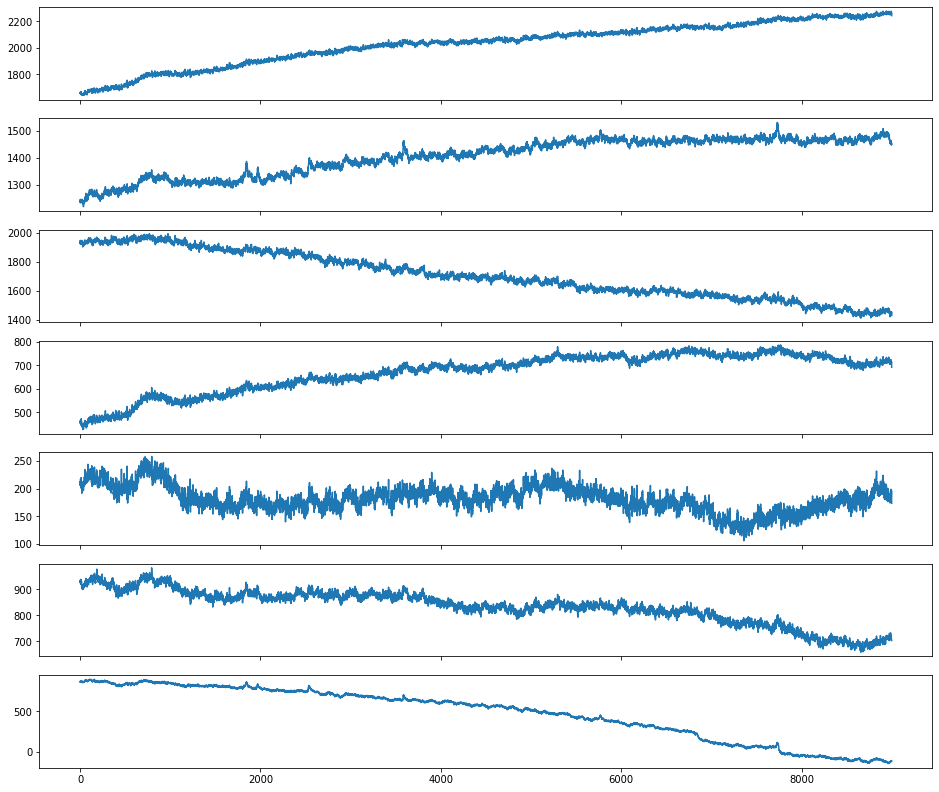

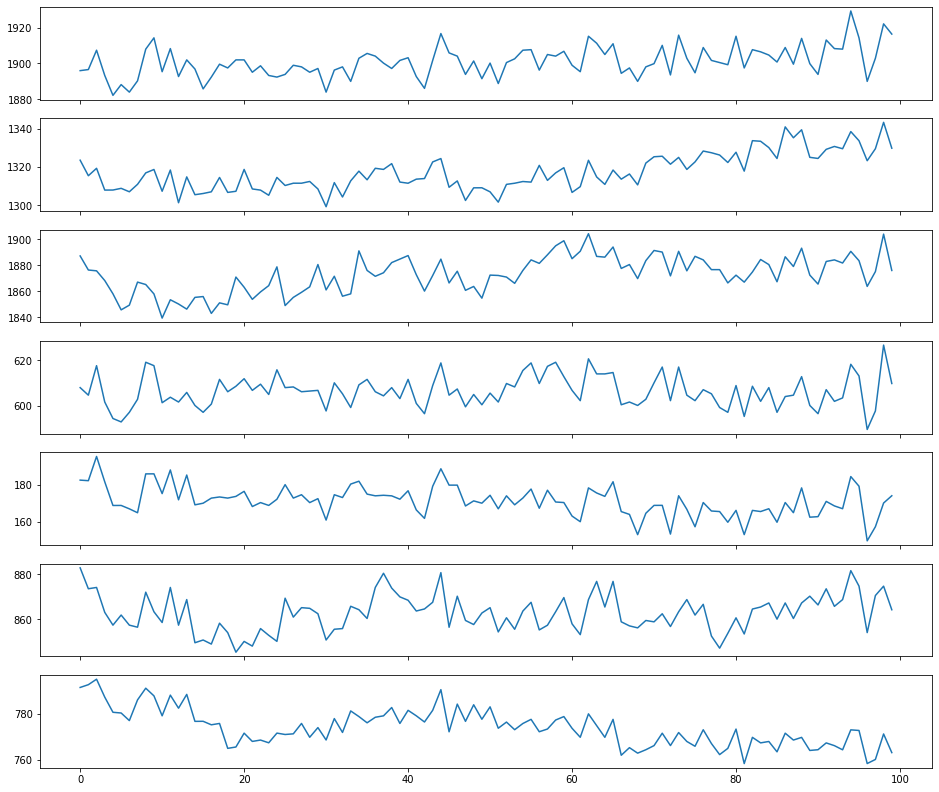

In [23]:
start = 2000
end = 2100

x = augmentor.x[0]
plot(x)
plot(x[:,start:end])


> Now we will filter the entire data set with a butter-bandpass filter using a low pass of 1Hz, a high pass of 30Hz, and using our sampling rate of 300Hz

(<Figure size 1152x1008 with 7 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

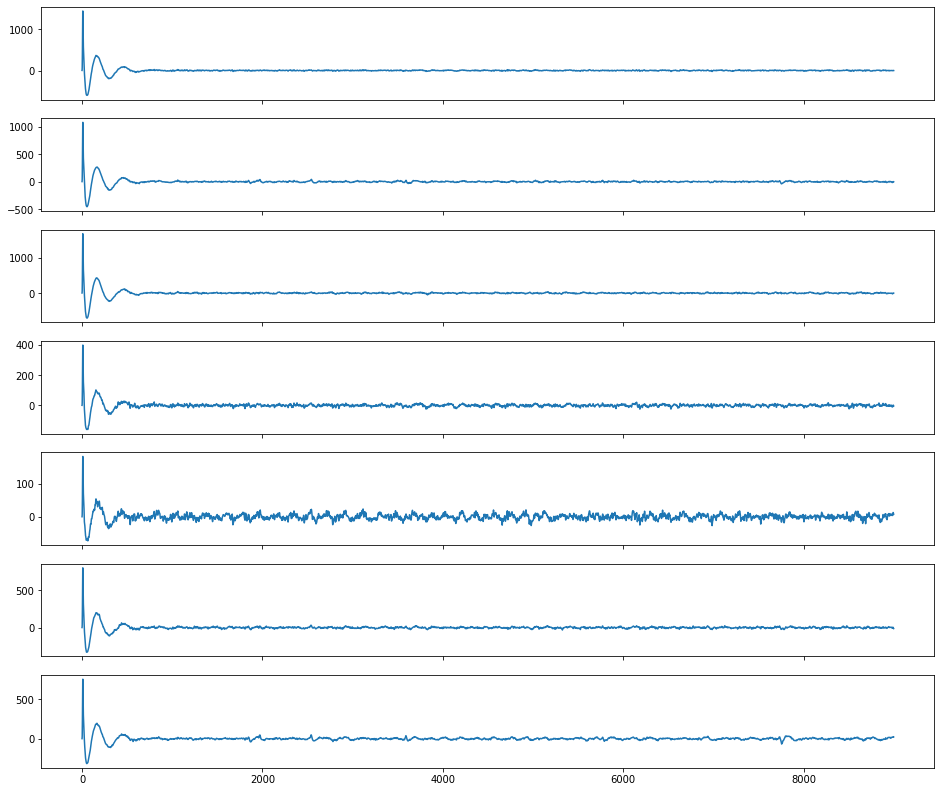

In [24]:
augmentor.x = butter_bandpass_filter(augmentor.x,lowcut,highcut,fs)
x_filtered = augmentor.x[0]
plot(x_filtered)

> The resulting above figure is a bit harder to interpret, because of the scale all of the values seem so close to zero, when in actuality, they are not, so let us zoom in a little bit on a 100ms section, (2000-2100ms)

(<Figure size 1152x1008 with 7 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

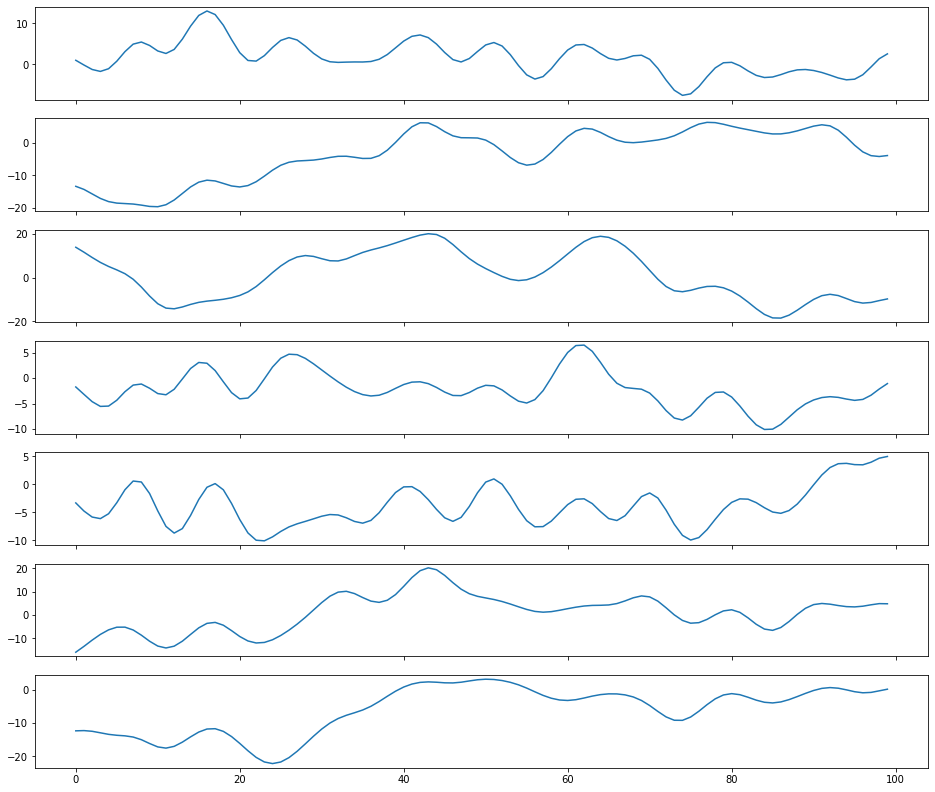

In [25]:
plot(x_filtered[:,start:end])

> As we can see, the new filtered signals now have an increased signal to noise ratio, and we can now perform augmentation on the filtered signals

> In order to properly augment our data, we once more need to transpose all entries of our data so that the shape is compatible with the tsaug library

In [26]:
augmentor.x = transposeDataset(augmentor.x)

> The below code will crop our entire data set in a row-wise fashion

In [27]:
cropSize = 50
numCrops = 5

augmentor.cropData(cropSize,numCrops)

> Let us see the new shape of our data now

In [28]:
augmentor.x.shape

(500, 50, 7)

> Originally, we had twenty entries, so now how do we have 500? Let's take a deep dive into this 'mysterious' cropData function

In [29]:
def cropData(self, cropSize,numCrops):
        augmentor = (
            Crop(size=cropSize,repeats=numCrops)
          + AddNoise(scale=[0.01,0.05,0.1],repeats=numCrops)
        )

        self.x = augmentor.augment(array(self.x))
        self.correctLabels()

> We first define our augmentation pipeline where we first crop from our dataset(in a column wise fashion), and then to each 
cropped segment of data we add Gaussian noise to it, with mean 0 and a scale parameter randomly sampled from the 'scale' list
we have passed into tsaug's AddNoise augmentor.

> We had 20 original observations, so if for each entry we crop from it five times, and then add noise to the five cropped observations also five times, then we will have a total of 20 * 5 * 5 = 500 resulting feature vectors

## PCA with no GMM 

> We use a feature extraction method using PCA on resulting means and variances of applying the EM-algorithm assuming a bayesian prior that our signals can be modeled by a mixture of Gaussian distributions, but before we dive into that, let's see how quality of a model we can create with just PCA

> We first need to reshape our data into vectors, rather than the channel representation as 50x7 matrices, so the resulting vector will have a length of 350 - that is too many dimensions, surely all of them are not useful?! We will see that is certainly the case below.

In [30]:
dataset = reshape(augmentor.x, [len(augmentor.x), cropSize * Visualizer.NUM_CHANNELS])

> Below is some basic functionality from sklearn to get the principal components of our massive 350-dimensional vectors. Let us first see how many components we should keep

In [31]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from numpy import array,transpose,reshape
import matplotlib.pyplot as plt
from numpy import mean,set_printoptions


def applyPCA(dataset,n_components):
    return PCA(n_components).fit_transform(dataset)

def fitPCA(dataset,n_components):
    return PCA(n_components).fit(dataset)

In [32]:
set_printoptions(suppress=True,formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

In [33]:
n_components = len(dataset[0])
pca = fitPCA(dataset,n_components)
pca.explained_variance_ratio_

array([           0.444,            0.400,            0.088,            0.027,            0.013,            0.007,
                  0.006,            0.004,            0.002,            0.001,            0.001,            0.001,
                  0.001,            0.001,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,  

> As we can see, a lot of our components are not needed, and we can produce a much lower-dimensional representation of our original 350 dimensional data with let's say, five components. In fact, let's see below exactly how much of the variance is accounted for with our first five components

In [34]:
n_components = 5
sum(pca.explained_variance_ratio_[0:n_components])

0.9721757082725572

> Let's now apply the change of basis transformation onto our original dataset and train a Random Forest Classifier as a bench mark before we move onto creating a more robust model with a Keras NN. 

In [35]:
dataset_no_gmm = applyPCA(dataset,n_components)

> Below we are defining our classifier, creating testing and training sets, and then evaluating our model accuracy, all in one function that we can reuse later on in this note book. We arbritarily choose a positive label of 'L', instead of adding a fifth parameter to the function

In [36]:
from sklearn.metrics import precision_score,recall_score

In [37]:
def getMetrics(x,y,model,test_split):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_split)
    model.fit(x_train,y_train)
    
    y_pred = model.predict(x_test)
    
    training_acc = model.score(x_train,y_train)
    testing_acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label='L')
    recall = recall_score(y_test,y_pred,pos_label='L')
    
    print(f'Training Accuracy: {training_acc} \n Testing Accuracy:{testing_acc} \n Precision: {precision} \n Recall: {recall}')
    

In [38]:
X = dataset_no_gmm
y = array(augmentor.y)
model = RandomForestClassifier(n_estimators=20,max_depth=5)
test_split = 0.25

getMetrics(X,y,model,test_split)

Training Accuracy: 0.9653333333333334 
 Testing Accuracy:0.888 
 Precision: 0.8548387096774194 
 Recall: 0.9137931034482759


## What are Gaussian Mixture Models?

> The accuracy is a bit too high it seems, and this certainly seems like a case of over-fitting. I can say with almost absolute certainty that this would not be a good model in an online EEG classification setting. Let us see now how the usage of Gaussian Mixture Models will compare.
> Before we do that, however, let us learn exactly through code what is a Gaussian Mixture. If you already know about GMMs 
> then you can skip this section

> Most real world phenomena is not modeled by one single instance of a distribution, but rather through a mixture of them. Here is a real life example from Google:

> 'Example: There are 67 cars and 33 trucks on a road, with the weight of cars distributed as Normal(3200, 300) , and truck as Normal(12K, 4K)'

> In the above scenario, it would be a bit awkward to try to assign only one Gaussian Distribution to the random variable, W, where W is the weight of a vehicle on this road of cars and trucks. If you think about what this would look like, it is a bimodal distribution of weights that is not captured by the unimodal nature of a single Gaussian distribution. Let us first see what these two distributions
look like individually

In [39]:
import seaborn as sns
from numpy.random import normal,randint

<AxesSubplot:title={'center':'Distribution of Weight of Vehicles'}, ylabel='Count'>

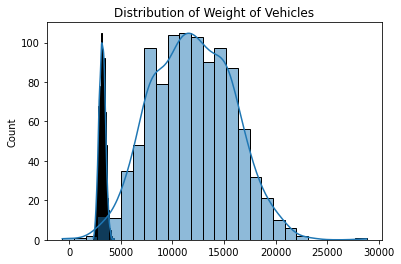

In [40]:
num_samples = 1000

mu_car = 3200
sigma_car = 300

mu_truck = 12000
sigma_truck = 4000

W_car = [normal(mu_car,sigma_car) for sample in range(num_samples)]
W_truck = [normal(mu_truck,sigma_truck) for sample in range(num_samples)]

sns.histplot(W_car,kde=True).set(title='Distribution of Weight of Vehicles')
sns.histplot(W_truck,kde=True)

> Now let us see what their mixture looks like

[Text(0.5, 1.0, 'Gaussian Mixture of Weight of Vehicles')]

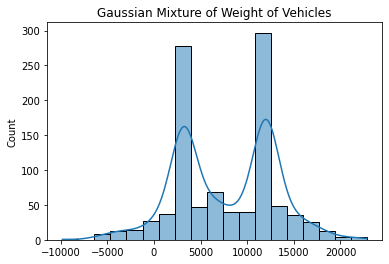

In [41]:
mu = [mu_car,mu_truck]
sigma = [sigma_car,sigma_truck]

W = [normal(mu[randint(0,len(mu))],sigma[randint(0,len(sigma))]) for sample in range(num_samples)]
sns.histplot(W,kde=True).set(title='Gaussian Mixture of Weight of Vehicles')

> As we can see, there are two distinct peaks in the above mixture, approximately at the mean weight of cars, and the
> mean weight of the trucks

> However, how do we write the probability density function for this mixture model? It is simply a linear combination
 of the proportion of values that come from each distribution in the mixture, and the probability density function of the individual distributin. This can also be thought of as a weighted sum, where the weights, known as mixing weights, represent the probability that some random value sampled from our mixture is from it's associated PDF that it is being multiplied with in this weighted sum. If we have K of these mixing weights, then each individual weight is denoted as $\pi_k$           

> We can then write the PDF of the above mixture as the following:

##   $ f_m(w;\pi,\mu,\sigma) = \pi_{car}\frac{1}{\sqrt{2\pi\sigma_{car}^2}}e^{\frac{-(w-\mu_{car})^2}{2\sigma_{car}^2}} + \pi_{truck}\frac{1}{\sqrt{2\pi\sigma_{truck}^2}}e^{\frac{-(w-\mu_{truck}^2)}{2\sigma_{truck}^2}}$

### $\pi_{car} =67/100,   \pi_{truck} = 33/100 $, since we are told that there are 67 cars and 33 trucks

> More generally, a mixture model can be explicitly written as:

### $ f_m(x;\pi,\mu,\sigma) = \displaystyle\sum_{k=1}^{K}\pi_k\mathcal{N}(x;\mu_k,\sigma_k)$,
>  Where $\pi = \{\pi_1,\dots\,\pi_K\}, \mu = \{\mu_1,\dots\,\mu_K\}, \sigma = \{\sigma_1,\dots\,\sigma_K\}$

> Of course, the mixing weights and associated model parameters must be approximated. One way of doing this is through an algorithm called expectation maximization

> A detailed case study of applying Expectation Maximization to a Gaussian Mixture can be found here: https://stephens999.github.io/fiveMinuteStats/intro_to_em.html

> The above article assumes you have an understanding of Maximum Likelihood Estimation for univariate random variables


## Results with PCA and GMM 

In [42]:
from sklearn.mixture import GaussianMixture
from numpy import concatenate

> First, let us reshape our data to something more convenient for the functionality we are about to write to apply EM to multi-channel signal

In [43]:
dataset = reshape(dataset,[len(dataset),Visualizer.NUM_CHANNELS,cropSize])
dataset.shape

(500, 7, 50)

> Below is code that for a multi-channel signal will fit a GMM model to each channel, and then return the associated parameters. We are only interested in mean and variances in this case

In [44]:
def GMM(signal,n_components):
    return [GaussianMixture(n_components).fit(reshape(signal[channel],[-1,1]))
               for channel in range(Visualizer.NUM_CHANNELS)]

def get_gmm_params(signal,n_components):
    fitGMM = GMM(signal,n_components)
    means = [fitGMM[i].means_ for i in range(len(fitGMM))]
    covars = [fitGMM[i].covariances_[:,0,0] for i in range(len(fitGMM))]
    
    return array([array(means).ravel(),array(covars).ravel()]).ravel()


> Let us see an example of the use of this function below

In [45]:
exampleSignal = dataset[0]

n_components = 3
parameters = get_gmm_params(exampleSignal,n_components)

parameters

array([         -34.398,           -6.375,          -17.754,          -44.669,           -7.666,          -24.048,
                -23.500,          -45.387,           -7.391,           -2.296,          -23.886,          -54.772,
                 -3.664,          -57.487,          -29.133,          -33.286,          -18.022,            1.089,
                -24.384,            0.444,          -11.399,           37.173,           15.610,           10.252,
                 18.855,           34.385,           12.941,            3.780,            7.982,           66.415,
                 66.799,           25.536,          106.242,            2.561,           15.494,           63.419,
                 26.142,           33.528,            5.604,            7.835,           20.355,            6.069])

> The first 21 entries of the above list are associated with the means of Gaussian distributions in our mixture. Since we have seven channels, and we are modeling each channel with three mixtures, then we have a total of 21 distributions across all seven channels with 21 different means. The same logic applies for the variances, hence, we have a total of 42 entries in this vector,or, more generally, the product of the number of channels in our signal, the number of mixtures we wish to model each individual channel with, and the number of parameters we are interested in approximating, as, of course, there is more than just Gaussian Mixtures

> Let us now get all of our feature vectors with this methodology. Because we are applying the EM Algorithm 500 times on seven channels each, so in effect 3500 times, this code cell will take a bit longer to run. Creating of more efficient algorithms to approximate the associated parameters of distributions in a mixture is actually an area of research of its own!

In [46]:
n_components = 8

dataset_gmm = [get_gmm_params(dataset[i],n_components) for i in range(len(dataset))]

> Just as a quick sanity check, we make sure we have the appropriate shape for our data

In [47]:
array(dataset_gmm).shape

(500, 112)

> Now, like before, let's see how useful really are all 112 of these dimensions. 

In [48]:
n_components = len(dataset_gmm[0]) # This time, n_components refers to the number of principal components we wish to keep, 
                                   # and not the number of mixtures
    
gmm_pca = fitPCA(dataset_gmm,n_components)

In [49]:
pca.explained_variance_ratio_

array([           0.444,            0.400,            0.088,            0.027,            0.013,            0.007,
                  0.006,            0.004,            0.002,            0.001,            0.001,            0.001,
                  0.001,            0.001,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,            0.000,            0.000,
                  0.000,            0.000,            0.000,            0.000,  

> This time it seems as if by the time we get to our eigth principal components, the extra dimensions of our data do not add much value. Coincidentally, or maybe not, we also used eight mixtures, so perhaps some sort of relationship exists!

> Either way, let us now build our new data set and see how it does

In [50]:
n = 10
dataset_gmm_pca = applyPCA(dataset_gmm,n)

In [51]:
X = dataset_gmm_pca
y = augmentor.y
model = RandomForestClassifier(n_estimators=10,max_depth = 3)
testing_split = 0.33

In [52]:
getMetrics(X,y,model,testing_split)

Training Accuracy: 0.7283582089552239 
 Testing Accuracy:0.6242424242424243 
 Precision: 0.5816326530612245 
 Recall: 0.7307692307692307


> With this feature extraction methodology, we certainly experience a lower testing accuracy. On the surface this may seem worse, but ideally, we are avoiding inherent overfitting in our models. The accuracy here actually does seem a bit lower than what would be ideal for a model in production, but not to the same degree that the previous model was overfitting. 

> In my (Tekin's) experience, production ready models tend to hover around 70-80% testing accuracy. Of course, this is a much more nuanced discussion, and much more needs to be looked into before such a claim can be made.

> This is Gamma Group's current state of research on our motion imagery system that directly ties into our NeuroVR project. This model is meant to predict the intended direction of movement, and data was acquired through motion imagery exercises. Now that we have a working baseline, the next step is to acquire more data and use a Neural Network based approach to produce greater model stability and robustness that can be used in an online setting so that we can get to that sweet spot of a production ready model. Thank you for checking out our notebook.